# SI 630 Project: Fake Review Detection on [YelpZip](http://odds.cs.stonybrook.edu/yelpzip-dataset/) Dataset

Name: Mingliang Duanmu

## Data import

In [1]:
import pandas as pd
import numpy as np
import string
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_review = pd.DataFrame(pd.read_table("/content/drive/MyDrive/Project/YelpZip/reviewContent",names=["user_id","name","date","review"]))

In [4]:
df_review.head()

,user_id,name,date,review
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered..."
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...


In [5]:
df_metadata = pd.DataFrame(pd.read_table("/content/drive/MyDrive/Project/YelpZip/metadata",names=["user_id", "prod_id", "rating", "label", "date"]))

In [6]:
df_metadata.head()

,user_id,prod_id,rating,label,date
0,5044,0,1.0,-1,2014-11-16
1,5045,0,1.0,-1,2014-09-08
2,5046,0,3.0,-1,2013-10-06
3,5047,0,5.0,-1,2014-11-30
4,5048,0,5.0,-1,2014-08-28


In [7]:
df_all = pd.concat([df_review,df_metadata],axis=1,join="inner")
df_all = df_all.loc[:,~df_all.columns.duplicated()]

In [8]:
df_all.head()

,user_id,name,date,review,prod_id,rating,label
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",0,1.0,-1
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,0,1.0,-1
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,0,3.0,-1
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,0,5.0,-1
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,0,5.0,-1


In [9]:
print(len(df_all[df_all['label'] == -1]), "fake reviews")
print(len(df_all[df_all['label'] == -1]) / len(df_all), "fake ratio") 

80461 fake reviews
0.13223755789224564 fake ratio


## Basic feature extraction

In [10]:
df_all['word_cnt'] = df_all['review'].apply(lambda x: len(x.split()))

In [11]:
def count_exlaim(review):
    count = 0
    for i in range(len(review)):
        if review[i] == '!':
            count += 1
    return count

df_all['exclaim_cnt'] = df_all['review'].apply(count_exlaim)

In [12]:
def count_caps(review):
    count = 0
    for item in review.split():
        if item.isupper():
            count += 1
    return count

df_all['all_cap'] = df_all['review'].apply(count_caps)

In [13]:
def count_sub(review):
    count = 0
    for item in review.split():
        item = item.translate(str.maketrans('', '', string.punctuation)).lower()
        if item in ['my', 'i', 'our', 'us', 'we']:
            count += 1
    return count

df_all['sub_cnt'] = df_all['review'].apply(count_sub)

## New

In [14]:
df_all.head()

,user_id,name,date,review,prod_id,rating,label,word_cnt,exclaim_cnt,all_cap,sub_cnt
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",0,1.0,-1,36,0,0,0
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,0,1.0,-1,248,0,4,9
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,0,3.0,-1,50,0,1,0
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,0,5.0,-1,233,2,9,11
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,0,5.0,-1,152,2,3,3


In [15]:
df_fake = df_all[df_all['label'] == -1]
df_real = df_all[df_all['label'] == 1].sample(len(df_fake), random_state=42)

In [19]:
df_all_train = pd.concat([df_fake, df_real])

In [20]:
len(df_all_train)

160922

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_all_train.drop(columns=['label', 'prod_id', 'user_id', 'date', 'name']), df_all_train['label'], test_size=0.2, random_state=42)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train['review'].tolist())
X_traint = vectorizer.transform(X_train['review'].tolist())
Xtestt = vectorizer.transform(X_test['review'].tolist())

In [42]:
X_train = pd.concat([X_train, pd.DataFrame(X_traint)])

In [51]:
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

names = ["Logistic Regression", "Linear SVM", "Decision Tree", "Random Forest", "GradientBoost"]

classifiers = [
    LogisticRegression(),
    LinearSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
]

In [52]:
for name, clf in zip(names, classifiers):
    clf.fit(X_traint, y_train)
    # evaluate predictions 
    score = clf.score(Xtestt, y_test)

    print("Accuracy:", score) 
  scores = cross_val_score(clf, X_traint ,y_train, cv=5, n_jobs=-1)
    print("Cross validation accuarcy score: %0.2f%% (+/- %0.2f)" % (scores.mean()*100, scores.std()*2*100))

Accuracy: 0.5548858163740873
Cross validation accuarcy score: 55.20% (+/- 0.38)
Accuracy: 0.5435451297188131
Cross validation accuarcy score: 53.98% (+/- 0.53)
Accuracy: 0.5170421003573094
Cross validation accuarcy score: 51.34% (+/- 0.47)
Accuracy: 0.5485163896224949
Cross validation accuarcy score: 54.72% (+/- 0.45)
Accuracy: 0.5581792760602765
Cross validation accuarcy score: 55.57% (+/- 0.63)


In [53]:
import torch

## EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_all.describe()

,user_id,name,prod_id,rating,label,word_cnt,exclaim_cnt,all_cap,sub_cnt
count,608458.000000,608458.000000,608458.000000,608458.000000,608458.000000,608458.000000,608458.000000,608458.000000,608458.000000
mean,89645.550291,2565.019737,2564.422090,3.923561,0.735525,115.320343,1.185720,3.568463,5.150211
std,73874.394788,1447.877997,1447.608727,1.147478,0.677498,106.188676,2.669422,4.623456,6.205445
min,5044.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,0.000000,0.000000,0.000000
25%,25497.000000,1345.000000,1344.000000,3.000000,1.000000,44.000000,0.000000,1.000000,1.000000
50%,66771.000000,2616.000000,2616.000000,4.000000,1.000000,85.000000,0.000000,2.000000,3.000000
75%,142275.750000,3768.000000,3768.000000,5.000000,1.000000,152.000000,2.000000,5.000000,7.000000
max,265320.000000,5043.000000,5043.000000,5.000000,1.000000,5333.000000,1080.000000,276.000000,238.000000


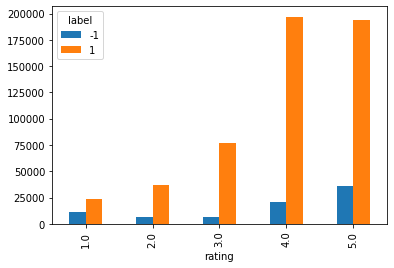

In [ ]:
_ = df_all.groupby(['rating', 'label']).size().unstack().plot.bar()

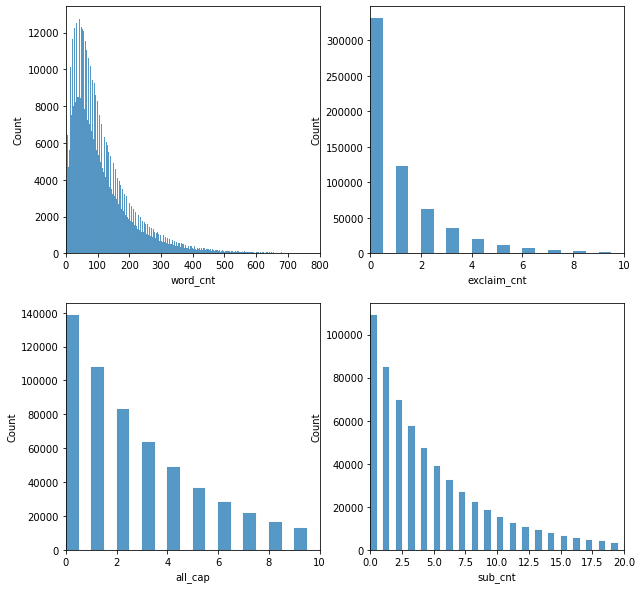

In [ ]:
f1, ((ax01, ax02), (ax03, ax04)) = plt.subplots(2, 2, figsize=(10,10))
sns.histplot(ax=ax01, data=df_all['word_cnt'])
_ = ax01.set_xlim(0, 800)
sns.histplot(ax=ax02, data=df_all['exclaim_cnt'], binwidth=0.5)
_ = ax02.set_xlim(0, 10)
sns.histplot(ax=ax03, data=df_all['all_cap'], binwidth=0.5)
_ = ax03.set_xlim(0, 10)
sns.histplot(ax=ax04, data=df_all['sub_cnt'], binwidth=0.5)
_ = ax04.set_xlim(0, 20)

In [ ]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wc = WordCloud(background_color="black", max_words=2000, stopwords=stopwords, contour_width=3, contour_color='steelblue')

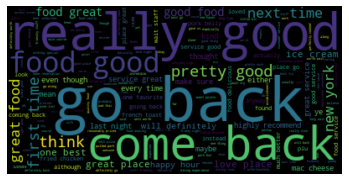

In [ ]:
wc.generate(' '.join(df_all['review'].tolist()).lower())
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

## Sentence embedding

In [ ]:
!pip install sentence_transformers

     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 2.1MB 15.6MB/s 
     |████████████████████████████████| 1.2MB 28.0MB/s 
     |████████████████████████████████| 3.3MB 53.7MB/s 
     |████████████████████████████████| 901kB 48.7MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=fa2cc3f41429310df4b7b7ce04131c72b7986ca6d97eac45206d6c1e27bee5e5
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
review_embeddings = model.encode(df_all['review'].tolist())

In [ ]:
df_embedding = pd.DataFrame(review_embeddings, columns=['dim_' + str(i + 1) for i in range(review_embeddings.shape[1])])

In [ ]:
df_embedding.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,dim_36,dim_37,dim_38,dim_39,dim_40,...,dim_729,dim_730,dim_731,dim_732,dim_733,dim_734,dim_735,dim_736,dim_737,dim_738,dim_739,dim_740,dim_741,dim_742,dim_743,dim_744,dim_745,dim_746,dim_747,dim_748,dim_749,dim_750,dim_751,dim_752,dim_753,dim_754,dim_755,dim_756,dim_757,dim_758,dim_759,dim_760,dim_761,dim_762,dim_763,dim_764,dim_765,dim_766,dim_767,dim_768
0,-0.618593,1.034102,-0.542357,0.092956,-0.570880,0.224063,1.591653,0.493728,0.947949,-0.207128,-0.127403,0.446528,0.297502,0.270761,-0.374107,0.348226,0.204612,0.015960,-0.045116,-0.205005,0.258282,-0.605837,0.533058,-0.287680,0.780120,0.856105,-0.443993,0.764242,-1.475757,0.187983,0.106055,0.424304,-0.109687,0.005331,0.011499,0.909024,0.214622,-0.164029,0.198386,0.391766,...,0.135030,-0.145808,0.870796,-0.438888,-0.178321,-0.423731,0.175475,0.484145,0.787545,-0.595244,-0.165132,0.673369,-0.229032,0.711160,0.156712,-1.092877,0.353373,0.485093,-0.551299,0.768001,-0.370520,-0.134576,-0.381631,0.224888,-0.437669,1.132581,0.619506,-0.044723,-0.542538,0.177819,-0.225080,-0.422917,-1.278734,-2.194269,-0.296239,-0.502954,0.215282,-0.058402,0.365060,0.561887
1,-0.586955,0.916100,-0.168268,0.004247,-0.013768,-0.166687,0.990723,0.573349,0.234171,-0.131781,-0.165803,0.162451,0.773515,0.476020,-1.502032,-0.037749,0.458642,0.410338,0.066560,-0.136794,-0.148216,-0.189578,0.565437,-0.061856,1.027671,1.263848,-0.552742,-0.067895,-0.874694,0.299152,-0.471289,0.375817,-0.050027,-0.262024,-0.207804,-0.129780,0.636430,0.133185,0.319297,0.310062,...,-0.119677,-0.331368,0.200784,-0.604164,0.175388,-0.453115,0.055914,-0.013670,0.568170,-0.557079,-0.614736,-0.564971,0.714695,0.396351,-0.030790,-1.182516,0.216650,0.403756,-0.119939,0.446623,-0.158379,0.199127,-0.238374,-0.334962,-0.040977,1.837368,0.528325,-0.208395,-0.179565,-0.301300,-0.455277,-0.924303,-1.406252,-1.742072,0.404954,-0.666360,0.044010,0.608672,0.277468,0.171642
2,-0.574964,-0.104762,0.250052,0.298094,0.145949,-0.633180,0.089415,0.643274,0.742182,-0.602637,0.723868,0.395251,0.209761,-0.231139,-0.557204,0.529805,0.042647,-0.380110,0.676654,0.085062,-0.073283,-0.920625,-0.276321,-0.397055,0.491955,0.975952,-0.217193,0.705668,-0.240590,0.218749,0.167134,1.144973,0.235313,-0.182327,0.482968,0.913766,0.420024,0.836029,0.001613,0.892832,...,-0.343612,-0.577226,1.135692,-0.269578,0.093251,0.265175,-0.054906,0.189966,0.177659,-0.927829,-0.490915,0.787654,0.362413,0.193782,-0.108972,-1.141207,0.088912,0.325340,-0.154682,0.636059,-0.099790,-0.466354,0.142369,-1.966205,-0.496444,0.548399,0.287410,0.490699,-1.036926,0.183857,-0.538191,-1.604947,-1.314177,-1.954907,0.160168,-0.557287,0.071678,1.222897,0.067976,0.346040
3,-0.750282,1.016271,-0.450876,-0.203867,-0.186902,-0.455468,-0.251967,0.441852,0.479997,-1.037174,0.918703,0.910679,0.431333,-0.043824,-0.638333,0.735721,0.441906,-0.131130,0.167112,0.062372,-0.080846,-1.030982,-0.177906,-0.014636,0.820288,1.407295,-0.276563,0.833909,0.040151,0.412182,-0.179713,0.481454,0.092847,-0.723353,-0.281601,0.755481,0.350442,0.616825,-0.202818,0.210832,...,-0.364824,-0.033463,0.150349,-0.231125,-0.035499,-0.086063,-0.415099,0.539415,0.402391,-0.430980,-0.750529,-0.105213,0.655106,-1.092065,-0.191375,-0.591902,0.614201,0.293793,-0.693668,0.570791,-0.211658,-0.219913,-0.412429,-1.528066,-0.678638,0.942710,0.638559,0.396427,-0.854036,0.202667,-0.446750,-1.471178,-1.103243,-1.068020,0.152384,-0.849724,0.106311,0.375489,0.468904,0.186425
4,-0.663727,0.971273,0.766448,0.092937,-0.375281,-1.544616,-0.394269,0.535559,0.581117,-1.012621,0.460161,0.615673,0.513457,-0.007820,-0.532457,-0.000031,0.368190,-0.182252,0.126244,-0.308697,0.209701,-1.315796,-0.067115,-0.051495,1.019698,0.902867,-0.187737,1.098842,0.408372,0.455691,-0.358457,0.624065,0.072812,-1.201846,0.071565,0.979288,0.5

In [ ]:
df_embedding.to_csv('embeddings.csv', index=False)

## Dimension projection

In [ ]:
import spacy
import re

nlp = spacy.load('en_core_web_sm')
sw = nlp.Defaults.stop_words

def remove_punc(review):
    return re.sub(r'[^\w\s]+', '', review)

In [ ]:
def eval_dim(review):
    review = [item.lower() for item in remove_punc(review).split() if item not in sw]
    tokens = nlp(' '.join(review))
    dims = nlp('taste environment service')
    sim_list = []
    for dim in dims:
        sim_list.append(dim.similarity(tokens))
    return sim_list

In [ ]:
review_dims = []
for item in tqdm(list(df_all['review'])):
    review_dims.append(eval_dim(item))
    
review_dims = pd.DataFrame(np.array(review_dims), columns=['taste', 'environment', 'service'])


  0%|          | 27/608458 [00:09<60:54:07,  2.78it/s]

KeyboardInterrupt: ignored

In [ ]:
review_dims['user_id'] = df_all['user_id']

In [ ]:
review_dims

,taste,environment,service,user_id
0,0.278725,0.530733,0.461912,5044
1,0.446460,0.633366,0.611078,5045
2,0.267180,0.492200,0.531566,5046
3,0.426383,0.658924,0.583923,5047
4,0.490227,0.589041,0.534383,5048
...,...,...,...,...
608453,0.251075,0.397895,0.470010,119664
608454,0.516944,0.587660,0.543514,56277
608455,0.511488,0.644377,0.572413,265320
608456,0.279756,0.403566,0.472196,161722


## Train

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
names = ["Logistic Regression", "Linear SVM", "Decision Tree", "Random Forest", "GradientBoost"]

classifiers = [
    LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
]

In [ ]:
df_a = pd.concat([df_all, df_embedding], axis=1)

In [ ]:
df_fake = df_a[df_a['label'] == -1]

In [ ]:
df_real = df_a[df_a['label'] == 1].sample(len(df_fake), random_state=42)

In [ ]:
df_fr = pd.concat([df_fake, df_real])

In [ ]:
df_fr.shape

(160922, 779)

In [ ]:
for col in ['rating', 'word_cnt', 'exclaim_cnt', 'all_cap', 'sub_cnt']:
    df_fr[col] = pd.Series(StandardScaler().fit_transform(df_fr[col].values.reshape(-1,1)).reshape(-1))

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(df_fr.drop(columns=['label', 'prod_id', 'user_id', 'date', 'review', 'name']), df_fr['label'], test_size=0.2, random_state=42)

,rating,word_cnt,exclaim_cnt,all_cap,sub_cnt,dim_1,dim_2,dim_3,dim_4,dim_5,...,dim_759,dim_760,dim_761,dim_762,dim_763,dim_764,dim_765,dim_766,dim_767,dim_768
545256,4.0,64,0,1,1,-0.686760,0.422982,-0.186540,-0.315842,-0.518959,...,-0.591766,-1.336719,-0.860136,-1.585951,-0.244410,0.053629,0.030245,0.192054,0.229324,0.198459
407663,4.0,145,0,3,3,-0.629853,1.093673,-0.559489,-0.105427,-0.072952,...,-0.101739,-0.812816,-1.149254,-1.520461,0.276906,-0.523214,0.054755,0.056167,0.918220,0.396342
519205,4.0,77,0,6,7,-0.706406,0.417143,-0.398931,-0.124865,0.093078,...,-0.384929,-1.356432,-1.185656,-1.297588,0.119707,-0.486065,0.113703,0.321934,0.350030,0.337236
254027,2.0,44,4,4,2,-0.658198,0.705619,-0.253236,-0.201301,0.656498,...,-0.572812,-1.170319,-0.472619,-1.387852,-0.387842,-0.309115,0.165227,0.192354,0.263725,-0.176809
272024,5.0,122,4,2,4,-0.753655,0.870890,-0.085503,-0.220337,0.026654,...,-0.706646,-1.528432,-1.072040,-1.127120,-0.094393,-0.869364,0.045949,0.221954,0.390043,0.341383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50908,4.0,175,0,2,6,-0.659455,1.016670,-0.634208,0.155854,0.004269,...,-0.517546,-0.858844,-1.756802,-1.402763,0.346038,-0.902637,0.145791,0.157138,0.902541,0.428086
559294,2.0,41,3,1,1,-0.302653,0.539135,-0.646389,0.169474,-0.246027,...,-0.284310,-0.969976,-1.095063,-1.317016,0.357920,-0.358672,0.145009,0.263696,0.653108,-0.433688
412392,4.0,205,1,8,6,-0.359346,0.718809,0.595611,-0.018727,-0.029507,...,-0.714233,-1.381713,-1.040707,-1.124984,-0.089536,-0.377687,-0.068702,0.160590,-0.013087,-0.130629
229217,5.0,314,1,0,15,-0.337368,1.009092,0.195464,-0.126378,-0.235573,...,-0.862567,-1.113288,-1.329139,-1.804891,-0.145390,-0.633193,0.478731,0.216247,-0.336649,0.018107


In [ ]:
model = SVC()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.564890476930247


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(docx):
    return sent_analyzer.polarity_scores(docx.text)
from spacy.tokens import Doc
Doc.set_extension("sentimenter",getter=sentiment_scores)

In [ ]:
import spacy
import re
nlp = spacy.load('en_core_web_sm')
def remove_punc(string):
    return re.sub(r'[^\w\s]+', '', string)

In [ ]:
type(nlp)

spacy.lang.en.English

In [ ]:
nlp('I am bad')._.sentimenter['compound']

-0.5423

In [ ]:
fake['sent'] = fake['review'].apply(lambda x: nlp(x)._.sentimenter['compound'])

<ipython-input-100-261f5dd884a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake['sent'] = fake['review'].apply(lambda x: nlp(x)._.sentimenter['compound'])


In [ ]:
real['sent'] = real['review'].apply(lambda x: nlp(x)._.sentimenter['compound'])

<ipython-input-104-3726266611fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real['sent'] = real['review'].apply(lambda x: nlp(x)._.sentimenter['compound'])


In [ ]:
len(real[real['sent']<-0.9]) / len(real)

0.010712182076792103

In [ ]:
df_all

,user_id,name,date,review,prod_id,rating,label,word_cnt
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",0,1.0,-1,36
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,0,1.0,-1,248
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,0,3.0,-1,50
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,0,5.0,-1,233
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,0,5.0,-1,152
...,...,...,...,...,...,...,...,...
608453,119664,5039,2013-01-20,When I first moved to the area I must say I wa...,5041,5.0,1,48
608454,56277,5039,2012-11-12,Kind of pricey. I guess I expected a ridiculou...,5041,1.0,1,145
608455,265320,5039,2012-08-22,"Stopped by this restaurant yesterday, we just ...",5041,5.0,1,135
608456,161722,5039,2011-05-11,Finally checked out The Best Subs in Claremont...,5041,5.0,1,58


In [ ]:
import numpy as np

In [ ]:
np.random.seed(111112)

In [ ]:
df_all['rand'] = np.random.random_sample((len(df_all),))

In [ ]:
df_all['pred'] = df_all['rand'].apply(lambda x: -1 if x < 80461 / len(df_all) else 1)

In [ ]:
TN = len(df_all[(df_all['label'] == 1) & (df_all['pred'] == 1)])
FP = len(df_all[(df_all['label'] == 1) & (df_all['pred'] == -1)])
FN = len(df_all[(df_all['label'] == -1) & (df_all['pred'] == 1)])
TP = len(df_all[(df_all['label'] == -1) & (df_all['pred'] == -1)])

In [ ]:
print(TN, FP, FN, TP)

458106 69891 69893 10568


In [ ]:
(TP+TN) /(TN+FP+FN+TP)

0.7702651620982878